In [14]:
%matplotlib inline
from pymc3 import Gamma, Poisson, Normal, Model, sample, forestplot, NUTS, Metropolis, find_MAP, starting, traceplot
import theano.tensor as tt
from theano import function as fn
from theano import printing
import numpy as np
import scipy as sp

Here is the original model, implemented in BUGS:

    model
    {   
        # Set up data
            for(i in 1:Nsubj) {
                for(j in 1:T) {
        # risk set = 1 if obs.t >= t
                    Y[i,j] <- step(obs.t[i] - t[j] + eps)
        # counting process jump = 1 if obs.t in [ t[j], t[j+1] )
        #                      i.e. if t[j] <= obs.t < t[j+1]
                    dN[i, j] <- Y[i, j] * step(t[j + 1] - obs.t[i] - eps) * FAIL[i]
                }
            }

        # Model 
            for(j in 1:T) {
                for(i in 1:Nsubj) {
                    dN[i, j]   ~ dpois(Idt[i, j])              # Likelihood
                    Idt[i, j] <- Y[i, j] * exp(beta[1]*pscenter[i] + beta[2]*
                    hhcenter[i] + beta[3]*ncomact[i] + beta[4]*rleader[i] + beta[5]*dleader[i] + beta[6]*inter1[i] + beta[7]*inter2[i]) * dL0[j]    # Intensity
                }     
                dL0[j] ~ dgamma(mu[j], c)
                mu[j] <- dL0.star[j] * c    # prior mean hazard 
            }


        c ~ dgamma(0.0001, 0.00001)
        r ~ dgamma(0.001, 0.0001)


        for (j in 1 : T) {  dL0.star[j] <- r * (t[j + 1] - t[j])  } 
        # next line indicates number of covariates and is for the corresponding betas
        for(i in 1:7) {beta[i] ~ dnorm(0.0,0.00001)} 


    }

In [2]:
dta = dict(T=73, Nsubj=430, eps=0.0,  t=[1, 21, 85, 128, 129, 148, 178, 204,
                                         206, 210, 211, 212, 225, 238, 241,
                                         248, 259, 273, 275, 281, 286, 289,
                                         301, 302, 303, 304, 313, 317, 323,
                                         344, 345, 349, 350, 351, 355, 356,
                                         359, 364, 385, 386, 389, 390, 391,
                                         392, 394, 395, 396, 397, 398, 399,
                                         400, 406, 415, 416, 426, 427, 434,
                                         435, 437, 441, 447, 448, 449, 450,
                                         451, 453, 455, 456, 458, 459, 460,
                                         461, 462, 463],
obs_t = [460, 313, 435, 350, 435, 350, 350, 460, 460, 448, 225, 225, 396, 435, 396, 396, 453, 396, 456, 397, 397, 396, 395, 275, 449, 395, 395, 462, 302, 302, 458, 461, 396, 241, 389, 458, 304, 304, 395, 395, 364, 460, 415, 463, 396, 459, 441, 435, 396, 458, 437, 396, 356, 356, 396, 455, 396, 462, 399, 400, 350, 350, 395, 395, 441, 355, 85, 458, 128, 396, 386, 386, 386, 462, 458, 390, 390, 396, 396, 396, 427, 458, 395, 275, 275, 395, 359, 395, 395, 441, 395, 463, 178, 275, 463, 396, 396, 259, 396, 396, 458, 441, 396, 463, 396, 463, 435, 396, 437, 396, 398, 463, 460, 462, 460, 460, 210, 396, 435, 458, 385, 323, 323, 359, 396, 396, 460, 238, 441, 450, 392, 458, 396, 458, 396, 396, 462, 435, 396, 394, 396, 435, 458, 1, 395, 395, 451, 462, 458, 462, 396, 286, 396, 349, 449, 462, 455, 21, 463, 461, 461, 456, 435, 396, 460, 462, 462, 435, 435, 460, 386, 396, 458, 386, 461, 441, 435, 435, 463, 456, 396, 275, 460, 406, 460, 406, 317, 406, 461, 396, 359, 458, 463, 435, 462, 458, 396, 396, 273, 396, 435, 281, 275, 396, 447, 225, 447, 396, 435, 416, 396, 248, 396, 435, 435, 396, 461, 385, 396, 458, 458, 396, 461, 396, 448, 396, 396, 460, 455, 456, 463, 462, 458, 463, 396, 462, 395, 456, 396, 463, 396, 435, 459, 396, 396, 396, 395, 435, 455, 395, 461, 344, 396, 395, 396, 317, 396, 395, 426, 461, 396, 289, 441, 395, 396, 458, 396, 396, 435, 396, 395, 396, 441, 345, 396, 359, 435, 435, 396, 396, 395, 458, 461, 458, 212, 301, 458, 456, 395, 396, 395, 435, 396, 396, 303, 458, 460, 400, 396, 462, 359, 458, 396, 206, 441, 396, 458, 396, 462, 396, 396, 275, 396, 395, 435, 435, 462, 225, 458, 462, 396, 396, 289, 396, 303, 455, 400, 400, 359, 461, 396, 462, 460, 463, 463, 463, 204, 435, 435, 396, 396, 396, 463, 458, 396, 455, 435, 396, 396, 463, 396, 461, 463, 460, 441, 460, 435, 435, 460, 455, 460, 395, 460, 460, 460, 435, 449, 463, 462, 129, 391, 396, 391, 391, 434, 356, 462, 396, 349, 225, 396, 435, 461, 391, 391, 351, 211, 461, 212, 434, 148, 356, 458, 456, 455, 435, 463, 463, 462, 435, 463, 437, 460, 396, 406, 451, 460, 435, 396, 460, 455, 396, 398, 456, 458, 396, 456, 449, 396, 128, 396, 462, 463, 396, 396, 396, 435, 460, 396, 458],
FAIL= [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
pscenter= [
 -.01434325, -.01460965, .01322687, .00971885, -.03223412, -.01113493, -.01359567, -.03357866, -.0387039, -.0553269, -.03238896, -.07464545, -.07325128, -.07062459, -.07464545, -.07032613, -.0703005, .00965232, -.01408955, .00577483, -.00219072, -.00084567, .01643198, .06509522, .06824313, .07300876, .07300876, .01394272, .06824313, .02063087, .00383186, -.02573045, -.02410864, -.02272752, .05120398, -.00997729, -.00550709, -.02062663, -.03077685, -.01688493, .01035959, .01149963, .01149963, .01149963, .01149963, .01149963, .01149963, .01149963, .01149963, .01149963, .01149963, .01149963, .01149963, .01149963, .01149963, .0034338, .0376236, .00733331, .01520069, .03832785, .03832785, -.02622275, -.02622275, -.02622275, -.01492678, -.02897806, -.02897806, -.02897806, -.02847666, -.031893, -.03919478, -.04224754, -.04743705, -.0510477, -.031893, -.01129093, .01706207, .00193999, -.01503116, .003101, -.00083466, .02395027, -.07952866, -.08559135, -.07251801, -.06586029, -.08432532, -.0613939, -.081205, -.07540084, -.08488011, -.08488011, -.08488011, -.07492433, -.08907269, -.09451609, -.05301854, -.08980743, -.0771635, -.0771635, -.08650947, -.07856082, -.0771635, -.08204606, -.08178245, -.05263504, -.05355574, -.05109092, -.04696729, -.04696729, -.04696729, -.05257489, -.05303248, -.05348096, -.04983674, -.04699414, .00584956, -.00792241, -.01719816, -.02138029, -.01576016, -.04274812, -.04014061, .0471441, .0471441, .0471441, .0471441, .0471441, .0471441, .0471441, .04233112, .0471441, .04233112, .050568, .07388823, .0493324, .04512087, .03205975, .02913185, .06010427, .05324252, .06973204, .05579907, .01212243, .07962459, .05054695, .06672142, .14026688, .01734403, .06078221, .06543709, .06438115, .20126908, -.03138622, -.02180659, .01637333, -.02415774, .01828684, .03106104, .04268495, .01897239, .01591935, -.02367065, -.0619156, -.06403028, -.06851645, -.04821694, -.03889525, -.05023452, -.05013452, -.01557191, -.01171948, -.01362136, -.01174715, -.02707938, -.02634164, -.02634164, -.02634164, -.00692153, -.02381614, -.00890537, -.00611669, -.00894752, -.03551984, -.0252678, -.01513384, -.01016569, -.03551984, -.03773227, -.01978032, .06803483, .06706496, .10551275, .15091534, .03092981, .06556855, .10781559, .12671031, .0936299, .09362991, .09362991, .08294538, .09362991, .09362991, .09362991, .01177025, .02610553, .03546937, .03546937, .03546937, .034415, -.00305626, .04973665, .05103208, .07546701, .05306436, .00824125, .01961115, .01202359, -.02919447, -.01016712, .01756074, -.04035511, -.04753104, -.04463152, -.04845615, -.05010044, .00031411, -.07911871, -.08799869, -.07980882, -.09393142, -.08000018, -.07666632, -.07817401, -.07444922, -.07226554, -.08216553, -.0777643, -.07752042, -.05767992, -.04727952, -.03774814, -.06870384, -.05999847, -.05947695, .02989959, .04627543, .02772475, .02883079, .03642944, .02871235, .04148949, .04240279, .07747082, .07626323, .04268012, .03225577, .06468724, -.05140995, -.05399637, -.05351515, .07302427, .02432223, .0490674, .0490674, .0490674, .0490674, .09013112, .10476315, .10476315, .10476315, .10476315, .10476315, .10476315, .10476315, .10476315, .10476315, .10476315, .10476315, .10476315, .10476315, .07008056, .08666077, .01546215, .01667466, .03417671, .05253941, .04293926, .01496588, .02692172, -.03827151, .04809769, .08742411, .04533176, .01455173, .01831875, .02710811, .09834951, .09952456, .06993483, .02945534, .038731, .1181948, .04435538, .04435538, -.02357505, .05824019, .05820741, -.02357505, .09324722, .15534712, .07207468, .04692869, -.03490683, -.04404809, -.05054474, -.05325826, -.0474724, -.04905931, .01068221, .02879751, .00852646, .02693032, .01835589, .02989959, .02989959, .02989959, .04976377, .04439012, .03397319, .02989959, .02989959, .05468828, .04463226, .05886378, .06311052, .02989959, .04595331, .04203459, .01231324, -.01399783, .04595331, .00145386, .04601278, .06459354, -.0007196, .00012216, -.07614055, -.08435525, -.07957162, -.10299519, -.08156988, -.08225659, -.07449063, -.00210284, -.00797183, -.025355, -.01258251, -.04372031, -.03985972, -.03545086, -.03384566, -.04025533, -.07523724, -.05947702, -.061286, -.07666647, -.07663169, -.05902354, -.07652324, -.07645561, -.06258684, -.09604834, -.08813326, -.03292062, -.07848112, -.08239502, -.08316891, -.07244316, -.075417, -.07652324, -.07922532, -.08755959, -.08583414, -.07450142, -.08066016, -.06057205, -.07652324, -.06249051, -.08781742, -.086076, -.07652324, -.07696518, -.0618688, -.06073988, -.06524737, -.04419825, -.04489509, -.04390368, -.04358438, -.04489509, -.04520512, -.04187583, -.03653955, -.03973426, -.03753508, -.03569439, -.06789339, .06689456, .05526327, .05139003, .02641841, .04891529, .07078697, .06862645, .06832582, .04104258, -.00120631, .01947345, .04891779, .04891779, .03561932, .02576244, .03158225, .03608047, .08685057, .04632537, .06841581, -.02899643],
hhcenter= [ -.78348798, -.63418788, -.91218799, -.98388809, -.23518796, .11481193, -1.415588, -1.2535881, -.55738801, -.88128799, -1.109488, .05721192, -1.045788, -.30888793, .29651192, -.36688802, -.50058788, .02271203, -.59088796, -.04198809, .50561196, -.07418796, .98481184, .78921205, .09431199, -.06488796, 2.1662121, .08891205, 1.4004121, 1.316112, 1.9362121, 2.0107121, 1.150712, .31951192, -.23918791, -.1562881, -.9575879, -.07728811, .29641202, 1.2273121, 1.7717118, 1.5764117, .14181189, .72131211, 1.279212, .68241197, -.72808808, -.00488802, -.23938794, -1.000788, .55081207, -.52348799, 1.780612, -.35888812, .36481193, 1.5480118, -.03078791, 1.389112, .30211189, .70901209, -.16668792, 1.435812, .47001198, 2.0838118, 1.1673121, .18461208, -.30608794, 1.4470119, .23301201, -.58458799, .44011191, -.61948794, -.41388795, .263212, .66171199, .92451197, .78081208, .90991193, 1.6920118, 1.334012, 1.2101121, .41591194, -.48498794, -.73278803, -1.093588, .09911207, -.93418807, -.46908805, .0205119, .0535119, -.14228792, -.55708808, -.45498797, -.54008788, -.30998799, -.10958811, -.0960879, -.01338812, -.88168806, -.51788801, .36801198, .46621206, .13271193, -.11208793, -.76768798, -.54508799, -1.2773881, .16641192, .95871216, -.48238799, 1.6281118, -.18848796, -.49718806, -.41348812, -.31628796, -.59528798, -.11718794, -.57058805, -.59488791, -.21248789, -.65658802, -.56298798, -.52698797, -.65758795, -.04988809, .55341202, -.76328796, .254612, 1.3500118, -.54958791, 1.665812, .14671211, 1.963912, .29161194, -.56838793, 1.9371119, .90991193, -.39558789, .39521196, -.55208796, -.05268808, -.77368802, -.45428798, .05841212, -.45308802, -.12458798, .01431207, -.28228804, .79281193, -.26358792, -.54738802, -.38158795, -.54118794, -.72828788, -.58128804, .355912, -.24078794, -1.0384881, -.75038809, -.41018793, -.43538806, -1.566388, -.53388804, -.28388807, -1.2348881, -.69028801, -1.620088, -.78128809, -.54648799, -.92738789, .11871199, .26851204, .61571199, .82891208, 1.1985121, 1.012012, 1.0602121, -.02988811, .79301196, .67731196, .43991187, .9404121, .5254119, 1.0365119, 1.6220121, .61671191, -.50318807, 2.6073117, .02361206, -.60438794, -.79278797, -.18108793, -.48178813, -.44038793, -.22628804, -.07398792, .519512, .40211204, .582012, 1.830512, .80441195, .58801204, -.56368798, -1.5451881, .45991209, -.23448797, -.36918804, 1.3247118, .19541197, -.20818801, 1.163012, -.78228801, -.6048879, -.575288, 1.3241119, .0147119, -.76518792, -.37478802, -.35508797, -.90038794, -1.250888, -.46608803, -.98488802, -1.5185881, -.90908808, -1.048188, -.90138787, -.77278799, -1.248988, -.34448811, -.61628789, .38531187, -.51728791, -.00878807, -.60078806, -.45358798, .46301201, -.22048803, -.71518797, -.76478809, -.75028795, -.4952881, .01731209, -.83718795, .57951194, .54291207, .45341209, .16941194, 1.054112, .61721212, 2.2717118, 1.1593118, 2.0280118, .92281204, 1.0100121, -.1866879, 2.6503119, 2.3914118, -.19948788, -.36418793, -.9259879, -.71058792, -.1104879, .16971211, 1.474812, 1.9360118, 2.5344119, 2.0171118, 1.9387121, .55071193, -.03918811, .20681195, .40421203, -.75518793, -.45678803, -1.0271881, .77211195, 1.146812, -1.147788, -1.565588, -.34888789, 1.303812, 1.952312, 1.639112, .07731203, .25901201, -.45608804, -.5028879, .03641204, -.03808804, .38571194, .31831196, -.17648788, -.44528791, -.55918807, -.53108805, .39721206, -.06328794, -.34038803, -.05988808, -.89548796, -.03518792, .045512, -.1859879, -.039288, -.82568806, .01431207, .40091208, -.2531881, .030412, -.31918809, -.54958791, -.79078788, .36691192, -.324388, -1.0082881, -1.232188, -.53248805, -.23678799, -.89188808, .25111201, -.6766879, -.3565881, -.61228794, -.21078797, -1.0343881, -.58358806, -.15588804, -.39238808, -.67818803, -.19498797, 1.099412, 1.2767119, -.64068788, -.50678796, -.64058799, -.86918801, 1.4048119, -.59648794, .23331194, .68371207, .11251191, -.17128797, .17081194, -.44218799, -.48708794, .09591202, .20131211, -.20108791, -.02158805, -.48188803, -.3012881, -.55008787, -1.146188, -.82128805, -.87638801, -.54488796, -.60288805, -1.003088, -.25078794, -.14818807, -.14738794, -.80938786, -.85988802, -.90188807, -.94998807, -.75718802, -.37418792, -.66708797, 1.0981121, 1.1441121, .47381189, -.12958808, -.34358808, -.84328789, -.33498809, -.98088807, -.6903879, -1.284988, -.80838794, -.91838807, -.81848806, -.34488794, -.83438796, .12971191, .99381214, -.91608804, -.31808802, -.01018806, .98171192, -.91638798, -1.043988, -1.0103881, 1.451612, -.01528808, .02441196, -.41458794, .25691202, .18601207, -.815988, -.02908798, -.59088796, -.35608789, .79691201, 1.8123121, -.98588794, 1.548912, 2.3653121, -.09238812, .96741205, .05891208, -.15618797, -.5660879, -.28338811, -.10088798, 1.1663117, .21981196, .07151202, -.009088, -.49578807, .15441208, -.44488809, -.2677879, -.54388803, -.25468799, .68631202, -.88128799, -.84628791, -1.2549881, -.36198804],
ncomact= [ 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1],
rleader= [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
dleader= [ 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
inter1= [ -.01434325, -.01460965, 0, 0, 0, -.01113493, 0, 0, 0, -.0553269, -.03238896, 0, 0, -.07062459, -.07464545, -.07032613, 0, 0, -.01408955, 0, -.00219072, 0, 0, 0, 0, 0, .07300876, .01394272, 0, 0, 0, 0, 0, 0, .05120398, 0, -.00550709, -.02062663, -.03077685, -.01688493, 0, .01149963, 0, .01149963, .01149963, 0, 0, 0, 0, 0, 0, 0, 0, 0, .01149963, .0034338, .0376236, .00733331, 0, .03832785, .03832785, -.02622275, -.02622275, -.02622275, -.01492678, 0, 0, -.02897806, -.02847666, 0, 0, -.04224754, -.04743705, -.0510477, -.031893, 0, 0, 0, -.01503116, .003101, -.00083466, .02395027, -.07952866, 0, 0, -.06586029, 0, -.0613939, -.081205, -.07540084, -.08488011, -.08488011, 0, -.07492433, -.08907269, -.09451609, 0, -.08980743, 0, -.0771635, 0, 0, -.0771635, -.08204606, 0, -.05263504, 0, -.05109092, -.04696729, 0, -.04696729, 0, -.05303248, -.05348096, 0, 0, .00584956, -.00792241, -.01719816, 0, -.01576016, 0, -.04014061, 0, 0, 0, 0, 0, .0471441, 0, .04233112, 0, .04233112, 0, 0, .0493324, .04512087, .03205975, .02913185, 0, .05324252, 0, 0, 0, 0, .05054695, 0, .14026688, .01734403, .06078221, 0, 0, 0, -.03138622, 0, .01637333, 0, 0, 0, 0, .01897239, .01591935, 0, -.0619156, 0, -.06851645, 0, -.03889525, -.05023452, -.05013452, 0, 0, -.01362136, 0, 0, -.02634164, 0, 0, 0, 0, -.00890537, -.00611669, 0, 0, 0, -.01513384, 0, -.03551984, 0, -.01978032, 0, .06706496, .10551275, 0, .03092981, .06556855, 0, 0, 0, .09362991, 0, 0, 0, 0, 0, 0, .02610553, .03546937, 0, 0, .034415, 0, 0, 0, .07546701, 0, 0, 0, 0, -.02919447, -.01016712, 0, 0, 0, 0, -.04845615, -.05010044, 0, 0, 0, 0, 0, 0, -.07666632, 0, 0, -.07226554, -.08216553, -.0777643, 0, 0, -.04727952, 0, -.06870384, -.05999847, 0, 0, 0, .02772475, .02883079, .03642944, 0, .04148949, 0, 0, 0, .04268012, .03225577, 0, -.05140995, -.05399637, 0, 0, .02432223, 0, .0490674, .0490674, .0490674, 0, 0, 0, 0, 0, 0, 0, 0, .10476315, 0, 0, 0, 0, 0, .07008056, 0, 0, .01667466, 0, .05253941, .04293926, 0, .02692172, 0, 0, .08742411, .04533176, 0, .01831875, 0, .09834951, .09952456, 0, .02945534, .038731, 0, .04435538, 0, -.02357505, 0, 0, -.02357505, .09324722, 0, 0, 0, -.03490683, 0, -.05054474, 0, -.0474724, -.04905931, 0, .02879751, 0, 0, 0, 0, 0, 0, 0, .04439012, 0, .02989959, .02989959, .05468828, .04463226, 0, 0, 0, 0, 0, .01231324, -.01399783, .04595331, .00145386, 0, .06459354, -.0007196, 0, -.07614055, -.08435525, 0, -.10299519, 0, 0, 0, -.00210284, -.00797183, 0, 0, 0, 0, -.03545086, 0, 0, 0, 0, -.061286, -.07666647, 0, -.05902354, -.07652324, -.07645561, 0, 0, 0, -.03292062, 0, 0, 0, 0, -.075417, 0, -.07922532, 0, -.08583414, -.07450142, -.08066016, 0, 0, -.06249051, 0, 0, 0, 0, -.0618688, 0, -.06524737, -.04419825, -.04489509, 0, 0, 0, -.04520512, -.04187583, 0, 0, -.03753508, 0, 0, 0, 0, 0, 0, 0, 0, .06862645, 0, 0, -.00120631, .01947345, 0, 0, .03561932, 0, .03158225, .03608047, 0, 0, 0, -.02899643],

inter2= [-.78348798, -.63418788, 0, 0, 0, .11481193, 0, 0, 0, -.88128799, -1.109488, 0, 0, -.30888793, .29651192, -.36688802, 0, 0, -.59088796, 0, .50561196, 0, 0, 0, 0, 0, 2.1662121, .08891205, 0, 0, 0, 0, 0, 0, -.23918791, 0, -.9575879, -.07728811, .29641202, 1.2273121, 0, 1.5764117, 0, .72131211, 1.279212, 0, 0, 0, 0, 0, 0, 0, 0, 0, .36481193, 1.5480118, -.03078791, 1.389112, 0, .70901209, -.16668792, 1.435812, .47001198, 2.0838118, 1.1673121, 0, 0, 1.4470119, .23301201, 0, 0, -.61948794, -.41388795, .263212, .66171199, 0, 0, 0, 1.6920118, 1.334012, 1.2101121, .41591194, -.48498794, 0, 0, .09911207, 0, -.46908805, .0205119, .0535119, -.14228792, -.55708808, 0, -.54008788, -.30998799, -.10958811, 0, -.01338812, 0, -.51788801, 0, 0, .13271193, -.11208793, 0, -.54508799, 0, .16641192, .95871216, 0, 1.6281118, 0, -.49718806, -.41348812, 0, 0, -.11718794, -.57058805, -.59488791, 0, -.65658802, 0, -.52698797, 0, 0, 0, 0, 0, 1.3500118, 0, 1.665812, 0, 1.963912, 0, 0, 1.9371119, .90991193, -.39558789, .39521196, 0, -.05268808, 0, 0, 0, 0, -.12458798, 0, -.28228804, .79281193, -.26358792, 0, 0, 0, -.72828788, 0, .355912, 0, 0, 0, 0, -.43538806, -1.566388, 0, -.28388807, 0, -.69028801, 0, -.78128809, -.54648799, -.92738789, 0, 0, .61571199, 0, 0, 1.012012, 0, 0, 0, 0, .43991187, .9404121, 0, 0, 0, .61671191, 0, 2.6073117, 0, -.60438794, 0, -.18108793, -.48178813, 0, -.22628804, -.07398792, 0, 0, 0, 1.830512, 0, 0, 0, 0, 0, 0, -.36918804, 1.3247118, 0, 0, 1.163012, 0, 0, 0, 1.3241119, 0, 0, 0, 0, -.90038794, -1.250888, 0, 0, 0, 0, -1.048188, -.90138787, 0, 0, 0, 0, 0, 0, -.00878807, 0, 0, .46301201, -.22048803, -.71518797, 0, 0, -.4952881, 0, -.83718795, .57951194, 0, 0, 0, 1.054112, .61721212, 2.2717118, 0, 2.0280118, 0, 0, 0, 2.6503119, 2.3914118, 0, -.36418793, -.9259879, 0, 0, .16971211, 0, 1.9360118, 2.5344119, 2.0171118, 0, 0, 0, 0, 0, 0, 0, 0, .77211195, 0, 0, 0, 0, 0, 1.952312, 0, 0, .25901201, 0, -.5028879, .03641204, 0, .38571194, 0, 0, -.44528791, -.55918807, 0, .39721206, 0, -.34038803, -.05988808, 0, -.03518792, .045512, 0, -.039288, 0, .01431207, 0, 0, .030412, -.31918809, 0, 0, 0, -.324388, 0, -1.232188, 0, -.23678799, -.89188808, 0, -.6766879, 0, 0, 0, 0, 0, 0, 0, -.67818803, 0, 1.099412, 1.2767119, -.64068788, -.50678796, 0, 0, 0, 0, 0, .68371207, .11251191, -.17128797, .17081194, 0, -.48708794, .09591202, 0, -.20108791, -.02158805, 0, -.3012881, 0, 0, 0, -.87638801, -.54488796, 0, 0, 0, 0, -.14738794, 0, 0, 0, 0, -.75718802, -.37418792, 0, 1.0981121, 1.1441121, .47381189, 0, 0, 0, -.33498809, 0, 0, 0, 0, -.91838807, 0, -.34488794, 0, .12971191, .99381214, -.91608804, 0, 0, .98171192, 0, 0, 0, 0, -.01528808, 0, -.41458794, .25691202, .18601207, 0, 0, 0, -.35608789, .79691201, 0, 0, 1.548912, 0, 0, 0, 0, 0, 0, 0, 0, 1.1663117, 0, 0, -.009088, -.49578807, 0, 0, -.2677879, 0, -.25468799, .68631202, 0, 0, 0, -.36198804])

In [3]:
def load_data_cox(dta):
    array = lambda x : np.array(dta[x], dtype=float)
    t = array('t')
    obs_t = array('obs_t')
    pscenter = array('pscenter')
    hhcenter = array('hhcenter')
    ncomact = array('ncomact')
    rleader = array('rleader')
    dleader = array('dleader')
    inter1 = array('inter1')
    inter2 = array('inter2')
    fail = array('FAIL')
    return (t, obs_t, pscenter, hhcenter, ncomact,
            rleader, dleader, inter1, inter2, fail)

In [4]:
(t, obs_t, pscenter, hhcenter, ncomact, rleader,
     dleader, inter1, inter2, fail) = load_data_cox(dta)

In [5]:
X = np.array([pscenter, hhcenter, ncomact, rleader, dleader, inter1, inter2])

In [6]:
X.shape

(7, 430)

In [16]:
with Model() as model:
    
    T = len(t) - 1
    nsubj = len(obs_t)

    # risk set equals one if obs_t >= t
    Y = np.array([[int(obs >= time) for time in t] for obs in obs_t])
    # counting process. jump = 1 if obs_t \in [t[j], t[j+1])
    dN = np.array([[Y[i,j]*int(t[j+1] >= obs_t[i])*fail[i] for j in range(T)] for i in
                    range(nsubj)])

    c = Gamma('c', .0001, .00001)
    r = Gamma('r', .001, .0001)
    
    dL0_star = r*np.diff(t)
    
    mu = dL0_star * c # prior mean hazard
    
    dL0 = Gamma('dL0', mu, c, shape=T)

    beta = Normal('beta', np.zeros(7),
                  np.ones(7)*100, shape=7)

    linear_model = tt.exp(tt.dot(X.T, beta))
    idt = Y[:, :-1] * tt.outer(linear_model, dL0)

    dn_like = Poisson('dn_like', idt, observed=dN)

In [17]:
with model:
    trace = sample(2000, n_init=10000, init='advi_map')

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


         Current function value: 2811.898224
         Iterations: 921
         Function evaluations: 1020
         Gradient evaluations: 1010


Average ELBO = -2,859.50: 100%|██████████| 10000/10000 [00:29<00:00, 343.46it/s]
Finished [100%]: Average ELBO = -2,845.43
100%|██████████| 2000/2000 [02:03<00:00, 16.14it/s]


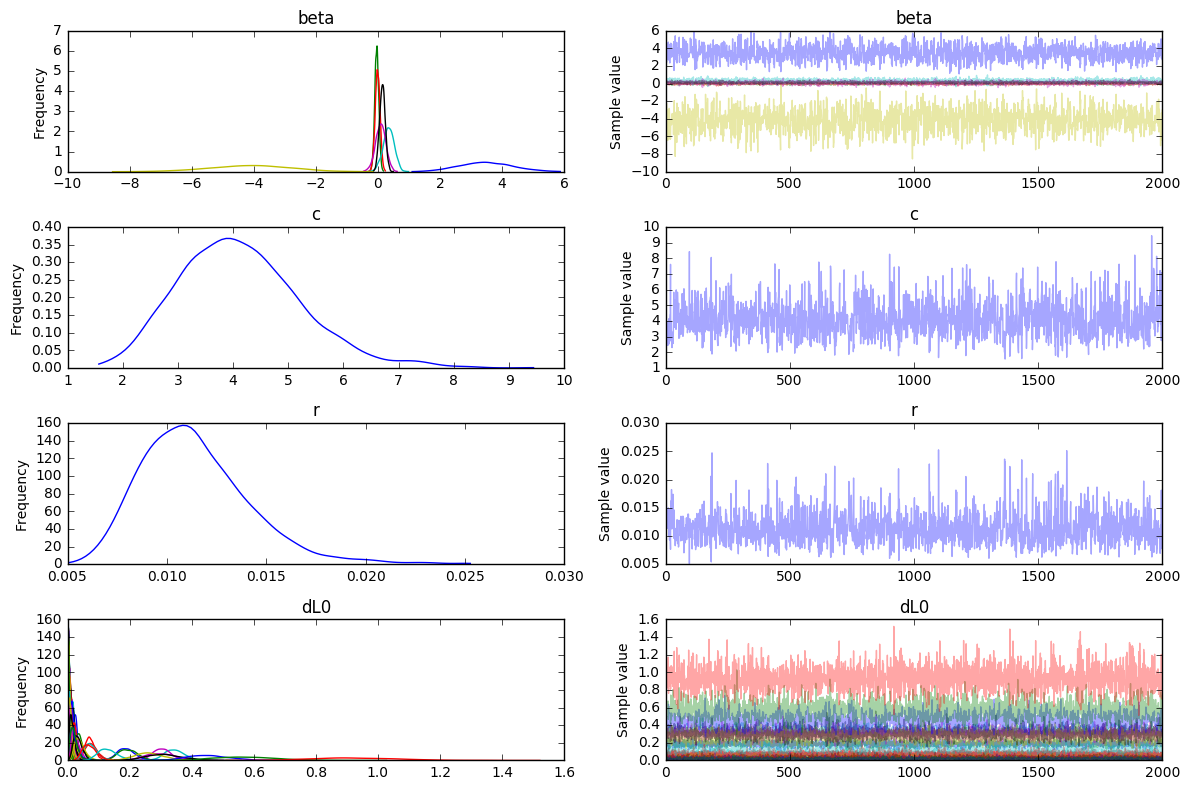

In [18]:
traceplot(trace);

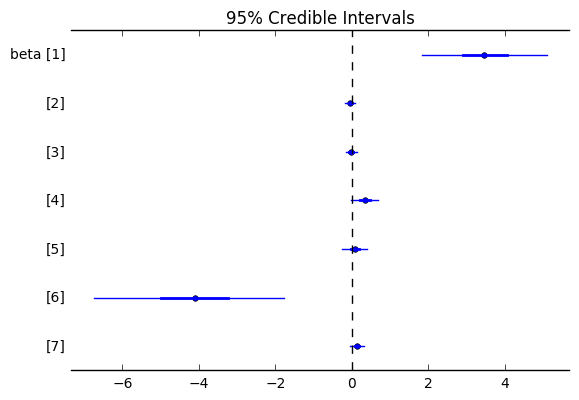

In [19]:
forestplot(trace, varnames=['beta'])